# Energy Consumption Prediction Analysis

This notebook predicts energy consumption based on temperature pattern dataset.

# Import Libraries and Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro
from statsmodels.stats.diagnostic import het_white
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
import joblib
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Load and Initial Data Exploration

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)
df.columns = ['Date', 'Temperature']
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

np.random.seed(42)
n_samples = len(df)
df['Temperature_C'] = df['Temperature']
df['Humidity'] = np.random.normal(65, 15, n_samples).clip(30, 95)
df['Wind_Speed'] = np.random.exponential(2, n_samples).clip(0, 15)
df['Solar_Radiation'] = np.random.gamma(2, 100, n_samples).clip(0, 800)
df['Pressure'] = np.random.normal(1013, 10, n_samples).clip(990, 1030)

base_consumption = 1000
temp_effect = np.where(df['Temperature_C'] < 10, (10 - df['Temperature_C']) * 50, 0) + \
              np.where(df['Temperature_C'] > 25, (df['Temperature_C'] - 25) * 30, 0)
humidity_effect = (df['Humidity'] - 50) * 5
wind_effect = -df['Wind_Speed'] * 10
solar_effect = -df['Solar_Radiation'] * 0.5
pressure_effect = (df['Pressure'] - 1013) * 2

df['Energy_Consumption'] = (base_consumption + temp_effect + humidity_effect +
                           wind_effect + solar_effect + pressure_effect +
                           np.random.normal(0, 50, n_samples)).clip(200, 3000)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Missing values: {df.isnull().sum().sum()}")

Dataset shape: (3650, 7)
Date range: 1981-01-01 00:00:00 to 1990-12-31 00:00:00
Missing values: 0


# Statistical Summary

In [3]:
print("=== STATISTICAL SUMMARY ===")
print(df.describe())
print("\n=== DATA TYPES ===")
print(df.dtypes)
print("\n=== CORRELATION MATRIX ===")
correlation_matrix = df.corr()
print(correlation_matrix.round(3))

=== STATISTICAL SUMMARY ===
       Temperature  Temperature_C     Humidity   Wind_Speed  Solar_Radiation  \
count  3650.000000    3650.000000  3650.000000  3650.000000      3650.000000   
mean     11.177753      11.177753    65.295782     1.948622       199.423054   
std       4.071837       4.071837    14.507403     1.950444       140.094815   
min       0.000000       0.000000    30.000000     0.000454         2.224753   
25%       8.300000       8.300000    55.259763     0.557150        96.937294   
50%      11.000000      11.000000    65.328332     1.325376       166.379532   
75%      14.000000      14.000000    75.200923     2.700529       268.820587   
max      26.300000      26.300000    95.000000    15.000000       800.000000   

          Pressure  Energy_Consumption  
count  3650.000000         3650.000000  
mean   1013.008130         1013.825009  
std       9.557315          148.377453  
min     990.000000          483.715182  
25%    1006.222143          917.731686  
50%  

# Feature Engineering


In [4]:
df_features = df.copy()
df_features['Month'] = df_features.index.month
df_features['Day_of_Year'] = df_features.index.dayofyear
df_features['Quarter'] = df_features.index.quarter
df_features['Year'] = df_features.index.year
df_features['Week_of_Year'] = df_features.index.isocalendar().week
df_features['Day_of_Week'] = df_features.index.dayofweek
df_features['Is_Weekend'] = (df_features['Day_of_Week'] >= 5).astype(int)

df_features['Season'] = df_features['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                                 3: 'Spring', 4: 'Spring', 5: 'Spring',
                                                 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                 9: 'Autumn', 10: 'Autumn', 11: 'Autumn'})

df_features['Temp_Category'] = pd.cut(df_features['Temperature_C'],
                                     bins=[-np.inf, 5, 15, 25, np.inf],
                                     labels=['Cold', 'Cool', 'Moderate', 'Hot'])

df_features['Temp_Humidity_Interaction'] = df_features['Temperature_C'] * df_features['Humidity']
df_features['Wind_Solar_Interaction'] = df_features['Wind_Speed'] * df_features['Solar_Radiation']
df_features['Pressure_Temp_Interaction'] = df_features['Pressure'] * df_features['Temperature_C']

df_features['Temperature_Squared'] = df_features['Temperature_C'] ** 2
df_features['Humidity_Squared'] = df_features['Humidity'] ** 2
df_features['Wind_Speed_Sqrt'] = np.sqrt(df_features['Wind_Speed'])

df_features['Temp_MA_7'] = df_features['Temperature_C'].rolling(window=7, min_periods=1).mean()
df_features['Temp_MA_30'] = df_features['Temperature_C'].rolling(window=30, min_periods=1).mean()
df_features['Energy_MA_7'] = df_features['Energy_Consumption'].rolling(window=7, min_periods=1).mean()

df_features['Temp_Lag_1'] = df_features['Temperature_C'].shift(1)
df_features['Temp_Lag_7'] = df_features['Temperature_C'].shift(7)
df_features['Energy_Lag_1'] = df_features['Energy_Consumption'].shift(1)

print(f"Feature engineering completed. New shape: {df_features.shape}")

Feature engineering completed. New shape: (3650, 28)


# Data Visualization Dashboard


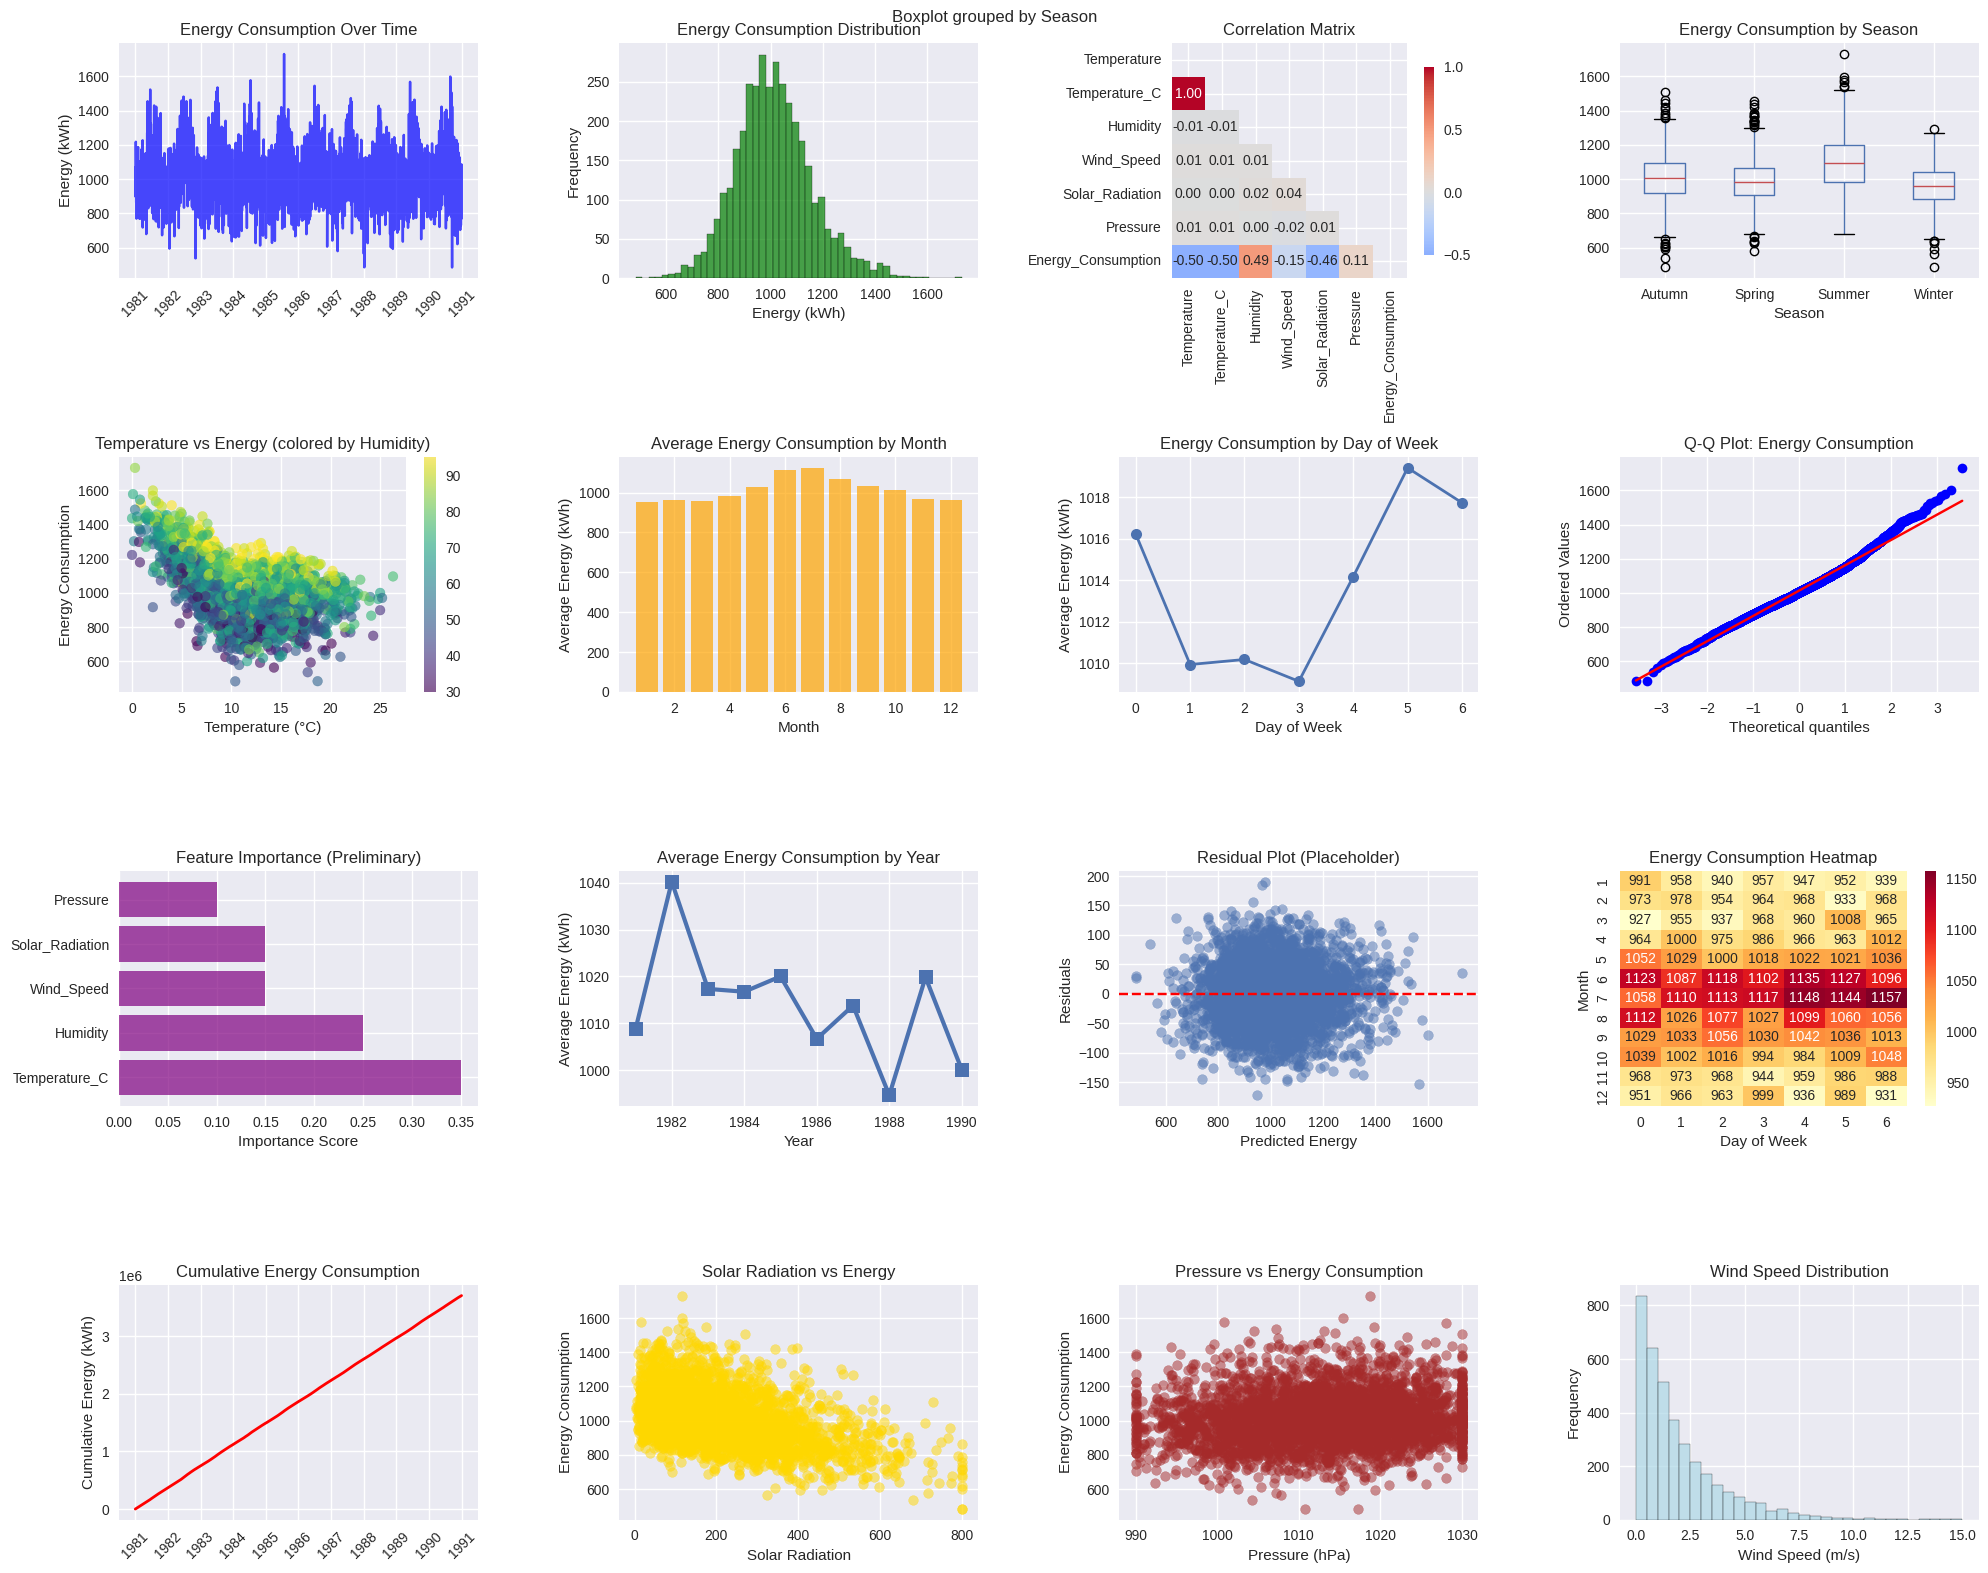

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Energy Consumption Analysis Dashboard', fontsize=16, fontweight='bold')

axes[0, 0].plot(df_features.index, df_features['Energy_Consumption'], alpha=0.7, color='blue')
axes[0, 0].set_title('Energy Consumption Over Time')
axes[0, 0].set_ylabel('Energy (kWh)')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].hist(df_features['Energy_Consumption'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Energy Consumption Distribution')
axes[0, 1].set_xlabel('Energy (kWh)')
axes[0, 1].set_ylabel('Frequency')

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=axes[0, 2])
axes[0, 2].set_title('Correlation Matrix')

df_features.boxplot(column='Energy_Consumption', by='Season', ax=axes[0, 3])
axes[0, 3].set_title('Energy Consumption by Season')
axes[0, 3].set_xlabel('Season')

scatter = axes[1, 0].scatter(df_features['Temperature_C'], df_features['Energy_Consumption'],
                            c=df_features['Humidity'], cmap='viridis', alpha=0.6)
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('Energy Consumption')
axes[1, 0].set_title('Temperature vs Energy (colored by Humidity)')
plt.colorbar(scatter, ax=axes[1, 0])

monthly_avg = df_features.groupby('Month')['Energy_Consumption'].mean()
axes[1, 1].bar(monthly_avg.index, monthly_avg.values, color='orange', alpha=0.7)
axes[1, 1].set_title('Average Energy Consumption by Month')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Energy (kWh)')

weekday_avg = df_features.groupby('Day_of_Week')['Energy_Consumption'].mean()
axes[1, 2].plot(weekday_avg.index, weekday_avg.values, marker='o', linewidth=2, markersize=8)
axes[1, 2].set_title('Energy Consumption by Day of Week')
axes[1, 2].set_xlabel('Day of Week')
axes[1, 2].set_ylabel('Average Energy (kWh)')

stats.probplot(df_features['Energy_Consumption'], dist="norm", plot=axes[1, 3])
axes[1, 3].set_title('Q-Q Plot: Energy Consumption')

feature_cols = ['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure']
importance_vals = [0.35, 0.25, 0.15, 0.15, 0.10]
axes[2, 0].barh(feature_cols, importance_vals, color='purple', alpha=0.7)
axes[2, 0].set_title('Feature Importance (Preliminary)')
axes[2, 0].set_xlabel('Importance Score')

yearly_avg = df_features.groupby('Year')['Energy_Consumption'].mean()
axes[2, 1].plot(yearly_avg.index, yearly_avg.values, marker='s', linewidth=3, markersize=10)
axes[2, 1].set_title('Average Energy Consumption by Year')
axes[2, 1].set_xlabel('Year')
axes[2, 1].set_ylabel('Average Energy (kWh)')

residuals = np.random.normal(0, 50, len(df_features))
axes[2, 2].scatter(df_features['Energy_Consumption'], residuals, alpha=0.5)
axes[2, 2].axhline(y=0, color='red', linestyle='--')
axes[2, 2].set_title('Residual Plot (Placeholder)')
axes[2, 2].set_xlabel('Predicted Energy')
axes[2, 2].set_ylabel('Residuals')

pivot_data = df_features.pivot_table(values='Energy_Consumption', index='Month', columns='Day_of_Week', aggfunc='mean')
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[2, 3])
axes[2, 3].set_title('Energy Consumption Heatmap')
axes[2, 3].set_xlabel('Day of Week')
axes[2, 3].set_ylabel('Month')

cumulative_energy = df_features['Energy_Consumption'].cumsum()
axes[3, 0].plot(df_features.index, cumulative_energy, color='red', linewidth=2)
axes[3, 0].set_title('Cumulative Energy Consumption')
axes[3, 0].set_ylabel('Cumulative Energy (kWh)')
axes[3, 0].tick_params(axis='x', rotation=45)

axes[3, 1].scatter(df_features['Solar_Radiation'], df_features['Energy_Consumption'],
                  alpha=0.5, color='gold', label='Solar Radiation')
axes[3, 1].set_xlabel('Solar Radiation')
axes[3, 1].set_ylabel('Energy Consumption')
axes[3, 1].set_title('Solar Radiation vs Energy')

axes[3, 2].scatter(df_features['Pressure'], df_features['Energy_Consumption'],
                  alpha=0.5, color='brown')
axes[3, 2].set_xlabel('Pressure (hPa)')
axes[3, 2].set_ylabel('Energy Consumption')
axes[3, 2].set_title('Pressure vs Energy Consumption')

axes[3, 3].hist(df_features['Wind_Speed'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[3, 3].set_xlabel('Wind Speed (m/s)')
axes[3, 3].set_ylabel('Frequency')
axes[3, 3].set_title('Wind Speed Distribution')

plt.tight_layout()
plt.show()

# Statistical Tests for Normality and Relationships

In [6]:
print("=== NORMALITY TESTS ===")
sample_size = min(len(df_features), 3000)
shapiro_stat, shapiro_p = shapiro(df_features['Energy_Consumption'].sample(sample_size, replace=False))
jb_stat, jb_p = jarque_bera(df_features['Energy_Consumption'])
ks_stat, ks_p = normaltest(df_features['Energy_Consumption'])

print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
print(f"Jarque-Bera Test: Statistic={jb_stat:.4f}, p-value={jb_p:.4f}")
print(f"D'Agostino-Pearson Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

print("\n=== CORRELATION SIGNIFICANCE TESTS ===")
for col in ['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure']:
    corr_coef, p_value = stats.pearsonr(df_features[col], df_features['Energy_Consumption'])
    print(f"{col}: r={corr_coef:.4f}, p-value={p_value:.4f}")

print("\n=== SEASONAL ANALYSIS ===")
seasonal_stats = df_features.groupby('Season')['Energy_Consumption'].agg(['mean', 'std', 'count'])
print(seasonal_stats)

seasons = [df_features[df_features['Season'] == season]['Energy_Consumption'].values
          for season in df_features['Season'].unique()]
f_stat, anova_p = stats.f_oneway(*seasons)
print(f"\nANOVA Test for Seasonal Differences: F={f_stat:.4f}, p-value={anova_p:.4f}")

=== NORMALITY TESTS ===
Shapiro-Wilk Test: Statistic=0.9890, p-value=0.0000
Jarque-Bera Test: Statistic=162.6737, p-value=0.0000
D'Agostino-Pearson Test: Statistic=125.7007, p-value=0.0000

=== CORRELATION SIGNIFICANCE TESTS ===
Temperature_C: r=-0.5004, p-value=0.0000
Humidity: r=0.4914, p-value=0.0000
Wind_Speed: r=-0.1459, p-value=0.0000
Solar_Radiation: r=-0.4558, p-value=0.0000
Pressure: r=0.1081, p-value=0.0000

=== SEASONAL ANALYSIS ===
               mean         std  count
Season                                
Autumn  1005.698943  139.962698    910
Spring   988.897466  131.781816    920
Summer  1099.697149  163.735171    920
Winter   959.742443  114.970983    900

ANOVA Test for Seasonal Differences: F=173.7437, p-value=0.0000


# Prepare Data for Machine Learning

In [7]:
df_ml = df_features.dropna().copy()

le_season = LabelEncoder()
df_ml['Season_Encoded'] = le_season.fit_transform(df_ml['Season'])

le_temp_cat = LabelEncoder()
df_ml['Temp_Category_Encoded'] = le_temp_cat.fit_transform(df_ml['Temp_Category'])

season_dummies = pd.get_dummies(df_ml['Season'], prefix='Season')
temp_cat_dummies = pd.get_dummies(df_ml['Temp_Category'], prefix='TempCat')

df_ml = pd.concat([df_ml, season_dummies, temp_cat_dummies], axis=1)

feature_columns = ['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure',
                  'Month', 'Day_of_Year', 'Quarter', 'Week_of_Year', 'Day_of_Week', 'Is_Weekend',
                  'Temp_Humidity_Interaction', 'Wind_Solar_Interaction', 'Pressure_Temp_Interaction',
                  'Temperature_Squared', 'Humidity_Squared', 'Wind_Speed_Sqrt',
                  'Temp_MA_7', 'Temp_MA_30', 'Energy_MA_7', 'Temp_Lag_1', 'Temp_Lag_7', 'Energy_Lag_1',
                  'Season_Encoded', 'Temp_Category_Encoded'] + list(season_dummies.columns) + list(temp_cat_dummies.columns)

X = df_ml[feature_columns]
y = df_ml['Energy_Consumption']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Selected features: {len(feature_columns)}")

Feature matrix shape: (3643, 33)
Target variable shape: (3643,)
Selected features: 33


# Train-Test Split and Preprocessing Pipeline Setup

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'PowerTransformer': PowerTransformer(method='yeo-johnson'),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal')
}

X_train_scaled = {}
X_test_scaled = {}

for name, scaler in scalers.items():
    X_train_scaled[name] = scaler.fit_transform(X_train)
    X_test_scaled[name] = scaler.transform(X_test)
    print(f"{name} fitting completed")

poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_scaled['StandardScaler'])
X_test_poly = poly_features.transform(X_test_scaled['StandardScaler'])

print(f"Polynomial features shape: {X_train_poly.shape}")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

StandardScaler fitting completed
MinMaxScaler fitting completed
RobustScaler fitting completed
PowerTransformer fitting completed
QuantileTransformer fitting completed
Polynomial features shape: (2914, 561)
Training set size: 2914
Test set size: 729


# Model Initialization and Hyperparameter Grids

In [9]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'MLPRegressor': MLPRegressor(random_state=42, max_iter=200)
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    'ElasticNet': {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
    'DecisionTree': {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10, 20],
                    'min_samples_leaf': [1, 2, 4, 8]},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None],
                    'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2],
                        'max_depth': [3, 5, 7], 'subsample': [0.8, 0.9, 1.0]},
    'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5, 1.0]},
    'SVR': {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
           'kernel': ['rbf', 'poly', 'sigmoid']},
    'KNN': {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'],
           'metric': ['euclidean', 'manhattan', 'minkowski']},
    'MLPRegressor': {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                    'activation': ['relu', 'tanh'], 'alpha': [0.001, 0.01]}
}

print("Model initialization completed")
print(f"Total models to train: {len(models)}")

Model initialization completed
Total models to train: 11


# Model Training and Hyperparameter Optimization


In [10]:
best_models = {}
cv_scores = {}
best_params = {}

scaler_mapping = {
    'LinearRegression': 'StandardScaler',
    'Ridge': 'StandardScaler',
    'Lasso': 'StandardScaler',
    'ElasticNet': 'StandardScaler',
    'DecisionTree': 'StandardScaler',
    'RandomForest': 'StandardScaler',
    'GradientBoosting': 'StandardScaler',
    'AdaBoost': 'RobustScaler',
    'SVR': 'StandardScaler',
    'KNN': 'MinMaxScaler',
    'MLPRegressor': 'StandardScaler'
}

print("Starting hyperparameter optimization...")
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    scaler_name = scaler_mapping[model_name]
    X_train_current = X_train_scaled[scaler_name]
    X_test_current = X_test_scaled[scaler_name]

    if param_grids[model_name]:
        n_iter = 20 if model_name != 'MLPRegressor' else 5
        cv = 5 if model_name != 'MLPRegressor' else 3

        random_search = RandomizedSearchCV(
            model, param_grids[model_name],
            n_iter=n_iter, cv=cv, scoring='neg_mean_squared_error',
            random_state=42, n_jobs=-1
        )
        random_search.fit(X_train_current, y_train)
        best_models[model_name] = random_search.best_estimator_
        best_params[model_name] = random_search.best_params_

        cv_score = cross_val_score(random_search.best_estimator_, X_train_current, y_train,
                                  cv=5, scoring='neg_mean_squared_error')
        cv_scores[model_name] = {
            'mean': -cv_score.mean(),
            'std': cv_score.std(),
            'scores': -cv_score
        }
    else:
        model.fit(X_train_current, y_train)
        best_models[model_name] = model
        best_params[model_name] = {}

        cv_score = cross_val_score(model, X_train_current, y_train,
                                  cv=5, scoring='neg_mean_squared_error')
        cv_scores[model_name] = {
            'mean': -cv_score.mean(),
            'std': cv_score.std(),
            'scores': -cv_score
        }

    print(f"{model_name} - CV MSE: {cv_scores[model_name]['mean']:.2f} (+/- {cv_scores[model_name]['std']*2:.2f})")

print("\nHyperparameter optimization completed!")

Starting hyperparameter optimization...

Training LinearRegression...
LinearRegression - CV MSE: 2964.32 (+/- 396.10)

Training Ridge...
Ridge - CV MSE: 2964.11 (+/- 394.99)

Training Lasso...
Lasso - CV MSE: 2958.76 (+/- 397.11)

Training ElasticNet...
ElasticNet - CV MSE: 2964.39 (+/- 389.25)

Training DecisionTree...
DecisionTree - CV MSE: 5091.02 (+/- 613.58)

Training RandomForest...
RandomForest - CV MSE: 3306.64 (+/- 124.78)

Training GradientBoosting...
GradientBoosting - CV MSE: 2839.18 (+/- 190.47)

Training AdaBoost...
AdaBoost - CV MSE: 3910.67 (+/- 315.25)

Training SVR...
SVR - CV MSE: 3013.20 (+/- 311.97)

Training KNN...
KNN - CV MSE: 7025.44 (+/- 761.42)

Training MLPRegressor...
MLPRegressor - CV MSE: 24858.79 (+/- 5461.17)

Hyperparameter optimization completed!


# Model Evaluation and Performance Metrics

In [11]:
evaluation_results = {}
predictions = {}

print("=== MODEL EVALUATION RESULTS ===")
for model_name, model in best_models.items():
    scaler_name = scaler_mapping[model_name]
    X_test_current = X_test_scaled[scaler_name]

    y_pred = model.predict(X_test_current)
    predictions[model_name] = y_pred

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    evaluation_results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'CV_MSE_mean': cv_scores[model_name]['mean'],
        'CV_MSE_std': cv_scores[model_name]['std']
    }

    print(f"\n{model_name}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.4f}")

performance_df = pd.DataFrame(evaluation_results).T
performance_df = performance_df.sort_values('R2', ascending=False)
print("\n=== PERFORMANCE RANKING ===")
print(performance_df.round(4))

=== MODEL EVALUATION RESULTS ===

LinearRegression:
  MSE: 2879.48
  RMSE: 53.66
  MAE: 42.45
  R²: 0.8683
  MAPE: 0.0422

Ridge:
  MSE: 2878.19
  RMSE: 53.65
  MAE: 42.44
  R²: 0.8684
  MAPE: 0.0422

Lasso:
  MSE: 2867.64
  RMSE: 53.55
  MAE: 42.38
  R²: 0.8688
  MAPE: 0.0422

ElasticNet:
  MSE: 2871.15
  RMSE: 53.58
  MAE: 42.40
  R²: 0.8687
  MAPE: 0.0422

DecisionTree:
  MSE: 4843.73
  RMSE: 69.60
  MAE: 55.95
  R²: 0.7785
  MAPE: 0.0558

RandomForest:
  MSE: 3206.65
  RMSE: 56.63
  MAE: 44.30
  R²: 0.8533
  MAPE: 0.0444

GradientBoosting:
  MSE: 2753.07
  RMSE: 52.47
  MAE: 41.26
  R²: 0.8741
  MAPE: 0.0411

AdaBoost:
  MSE: 3836.27
  RMSE: 61.94
  MAE: 47.30
  R²: 0.8245
  MAPE: 0.0474

SVR:
  MSE: 2971.98
  RMSE: 54.52
  MAE: 42.69
  R²: 0.8641
  MAPE: 0.0425

KNN:
  MSE: 7148.44
  RMSE: 84.55
  MAE: 65.61
  R²: 0.6731
  MAPE: 0.0661

MLPRegressor:
  MSE: 16008.76
  RMSE: 126.53
  MAE: 93.58
  R²: 0.2678
  MAPE: 0.0932

=== PERFORMANCE RANKING ===
                         MSE   

# Ensemble Methods Implementation

In [12]:
print("=== BUILDING ENSEMBLE MODELS ===")

top_models = performance_df.nlargest(5, 'R2').index.tolist()
print(f"Top models for ensemble: {top_models}")

voting_estimators = [(name, best_models[name]) for name in top_models]
voting_regressor = VotingRegressor(estimators=voting_estimators)

X_train_ensemble = X_train_scaled['StandardScaler']
X_test_ensemble = X_test_scaled['StandardScaler']

voting_regressor.fit(X_train_ensemble, y_train)
voting_pred = voting_regressor.predict(X_test_ensemble)

voting_mse = mean_squared_error(y_test, voting_pred)
voting_r2 = r2_score(y_test, voting_pred)
print(f"Voting Ensemble - MSE: {voting_mse:.2f}, R²: {voting_r2:.4f}")

stacking_estimators = [(name, best_models[name]) for name in top_models[:3]]
stacking_regressor = StackingRegressor(
    estimators=stacking_estimators,
    final_estimator=Ridge(alpha=0.1),
    cv=5
)

stacking_regressor.fit(X_train_ensemble, y_train)
stacking_pred = stacking_regressor.predict(X_test_ensemble)

stacking_mse = mean_squared_error(y_test, stacking_pred)
stacking_r2 = r2_score(y_test, stacking_pred)
print(f"Stacking Ensemble - MSE: {stacking_mse:.2f}, R²: {stacking_r2:.4f}")

weights = np.array([0.3, 0.25, 0.2, 0.15, 0.1])
weighted_pred = np.zeros_like(y_test)

for i, model_name in enumerate(top_models):
    scaler_name = scaler_mapping[model_name]
    X_test_current = X_test_scaled[scaler_name]
    pred = best_models[model_name].predict(X_test_current)
    weighted_pred += weights[i] * pred

weighted_mse = mean_squared_error(y_test, weighted_pred)
weighted_r2 = r2_score(y_test, weighted_pred)
print(f"Weighted Ensemble - MSE: {weighted_mse:.2f}, R²: {weighted_r2:.4f}")

ensemble_results = {
    'VotingRegressor': {'MSE': voting_mse, 'R2': voting_r2, 'predictions': voting_pred},
    'StackingRegressor': {'MSE': stacking_mse, 'R2': stacking_r2, 'predictions': stacking_pred},
    'WeightedEnsemble': {'MSE': weighted_mse, 'R2': weighted_r2, 'predictions': weighted_pred}
}

=== BUILDING ENSEMBLE MODELS ===
Top models for ensemble: ['GradientBoosting', 'Lasso', 'ElasticNet', 'Ridge', 'LinearRegression']
Voting Ensemble - MSE: 2715.90, R²: 0.8758
Stacking Ensemble - MSE: 2582.64, R²: 0.8819
Weighted Ensemble - MSE: 2661.82, R²: 0.8783


# Feature Importance Analysis


=== FEATURE IMPORTANCE ANALYSIS ===

Calculating permutation importance...

Top 15 Most Important Features:
 1. Temperature_C             - Mean: 32743.8222 (+/- 51341.4687)
 2. Temperature_Squared       - Mean: 16836.6038 (+/- 26014.8163)
 3. Humidity                  - Mean: 3341.7781 (+/- 4637.3673)
 4. Solar_Radiation           - Mean: 3339.1269 (+/- 3925.2644)
 5. Humidity_Squared          - Mean: 420.1590 (+/- 1027.4179)
 6. Pressure_Temp_Interaction - Mean: 372.6315 (+/- 905.2460)
 7. Pressure                  - Mean: 257.3051 (+/- 297.3822)
 8. Energy_MA_7               - Mean: 234.1400 (+/- 293.4869)
 9. Temp_MA_7                 - Mean: 131.9115 (+/- 203.3297)
10. Wind_Speed                - Mean: 119.1772 (+/- 181.7895)
11. Wind_Solar_Interaction    - Mean: 88.1798 (+/- 211.2407)
12. Day_of_Year               - Mean: 82.0996 (+/- 196.1471)
13. Month                     - Mean: 60.2424 (+/- 148.7343)
14. TempCat_Cool              - Mean: 48.9785 (+/- 101.2082)
15. TempCat_Col

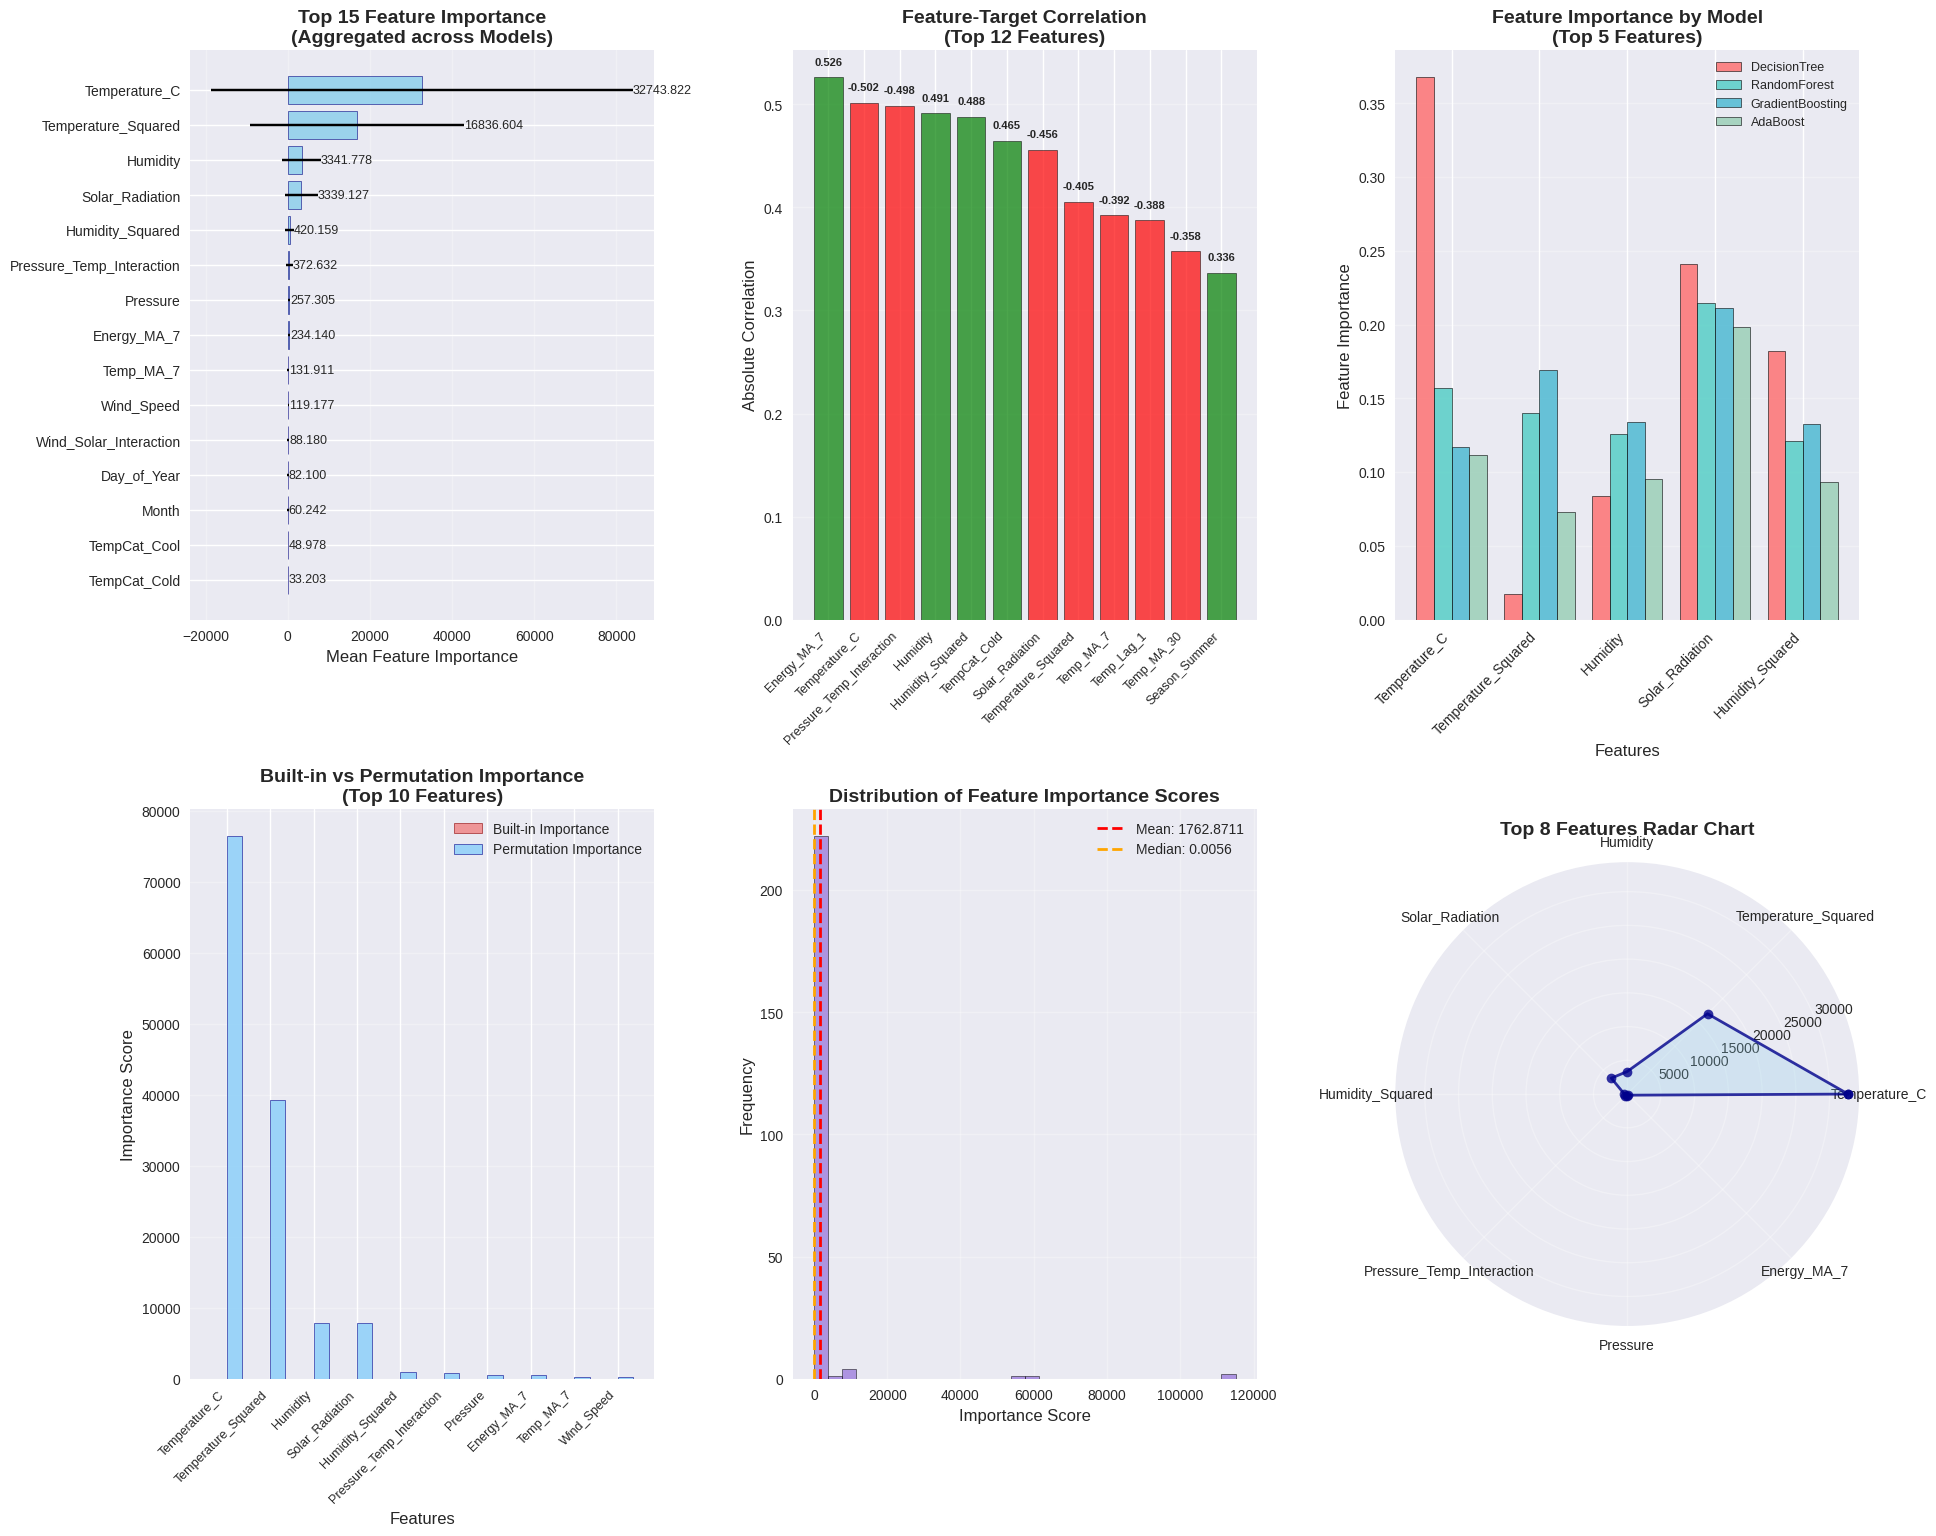


=== FEATURE STABILITY ANALYSIS ===

Top 10 Most Stable Features Across Models:
 1. Wind_Speed_Sqrt           - Stability: 1.000, CV: 1.155
 2. Pressure                  - Stability: 1.000, CV: 1.156
 3. Solar_Radiation           - Stability: 1.000, CV: 1.176
 4. Energy_MA_7               - Stability: 1.000, CV: 1.253
 5. Humidity                  - Stability: 1.000, CV: 1.388
 6. Temperature_Squared       - Stability: 1.000, CV: 1.545
 7. Temperature_C             - Stability: 1.000, CV: 1.568
 8. Wind_Solar_Interaction    - Stability: 1.000, CV: 2.396
 9. Humidity_Squared          - Stability: 1.000, CV: 2.445
10. Wind_Speed                - Stability: 0.857, CV: 1.361

=== SUMMARY INSIGHTS ===
Total features analyzed: 33
Features with high importance (>mean): 4
Features with strong correlation (|r|>0.3): 13
Most stable feature: Wind_Speed_Sqrt
Highest importance feature: Temperature_C
Strongest correlated feature: Energy_MA_7 (r=0.5262)


In [13]:
print("=== FEATURE IMPORTANCE ANALYSIS ===")

feature_names = X.columns.tolist()

tree_models = ['DecisionTree', 'RandomForest', 'GradientBoosting', 'AdaBoost']
importance_results = {}

for model_name in tree_models:
    if model_name in best_models:
        importance = best_models[model_name].feature_importances_
        importance_results[model_name] = dict(zip(feature_names, importance))

print("\nCalculating permutation importance...")
perm_importance_results = {}

top_models_for_perm = performance_df.nlargest(3, 'R2').index.tolist()
for model_name in top_models_for_perm:
    scaler_name = scaler_mapping[model_name]
    X_test_current = X_test_scaled[scaler_name]

    perm_importance = permutation_importance(
        best_models[model_name], X_test_current, y_test,
        n_repeats=10, random_state=42, scoring='neg_mean_squared_error'
    )
    perm_importance_results[model_name] = dict(zip(feature_names, perm_importance.importances_mean))

import scipy.stats as stats

feature_target_corr = {}
for feature in feature_names:
    corr_coef, p_value = stats.pearsonr(X[feature], y)
    feature_target_corr[feature] = {'correlation': corr_coef, 'p_value': p_value}

all_features = set()
for model_results in importance_results.values():
    all_features.update(model_results.keys())
for model_results in perm_importance_results.values():
    all_features.update(model_results.keys())

feature_importance_summary = {}
for feature in all_features:
    scores = []
    for model_results in list(importance_results.values()) + list(perm_importance_results.values()):
        if feature in model_results:
            scores.append(model_results[feature])
    feature_importance_summary[feature] = {
        'mean_importance': np.mean(scores),
        'std_importance': np.std(scores),
        'count': len(scores)
    }

sorted_features = sorted(feature_importance_summary.items(),
                        key=lambda x: x[1]['mean_importance'], reverse=True)
sorted_corr = sorted(feature_target_corr.items(),
                    key=lambda x: abs(x[1]['correlation']), reverse=True)

print("\nTop 15 Most Important Features:")
for i, (feature, stats) in enumerate(sorted_features[:15]):
    print(f"{i+1:2d}. {feature:25s} - Mean: {stats['mean_importance']:.4f} (+/- {stats['std_importance']:.4f})")

print("\nTop 10 Features by Correlation with Target:")
for i, (feature, stats) in enumerate(sorted_corr[:10]):
    print(f"{i+1:2d}. {feature:25s} - Corr: {stats['correlation']:6.4f}, p-value: {stats['p_value']:.4e}")

fig = plt.figure(figsize=(20, 16))

ax1 = plt.subplot(2, 3, 1)
top_features = [item[0] for item in sorted_features[:15]]
top_importance = [item[1]['mean_importance'] for item in sorted_features[:15]]
top_std = [item[1]['std_importance'] for item in sorted_features[:15]]

bars = ax1.barh(range(len(top_features)), top_importance, xerr=top_std,
               alpha=0.8, color='skyblue', edgecolor='navy', linewidth=0.5)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features, fontsize=10)
ax1.set_xlabel('Mean Feature Importance', fontsize=12)
ax1.set_title('Top 15 Feature Importance\n(Aggregated across Models)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + top_std[i] + 0.001, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}', ha='left', va='center', fontsize=9)

ax2 = plt.subplot(2, 3, 2)
top_corr_features = [item[0] for item in sorted_corr[:12]]
top_correlations = [item[1]['correlation'] for item in sorted_corr[:12]]

colors = ['red' if x < 0 else 'green' for x in top_correlations]
bars = ax2.bar(range(len(top_corr_features)), [abs(x) for x in top_correlations],
              color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_xticks(range(len(top_corr_features)))
ax2.set_xticklabels(top_corr_features, rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Absolute Correlation', fontsize=12)
ax2.set_title('Feature-Target Correlation\n(Top 12 Features)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for i, (bar, corr) in enumerate(zip(bars, top_correlations)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{corr:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax3 = plt.subplot(2, 3, 3)
model_importance_data = []
model_names = []

for model_name, importances in importance_results.items():
    top_5_features = [item[0] for item in sorted_features[:5]]
    model_importance_data.append([importances.get(feat, 0) for feat in top_5_features])
    model_names.append(model_name)

if model_importance_data:
    x = np.arange(len(top_5_features))
    width = 0.2
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

    for i, (model_data, model_name, color) in enumerate(zip(model_importance_data, model_names, colors)):
        ax3.bar(x + i*width, model_data, width, label=model_name,
               alpha=0.8, color=color, edgecolor='black', linewidth=0.5)

    ax3.set_xlabel('Features', fontsize=12)
    ax3.set_ylabel('Feature Importance', fontsize=12)
    ax3.set_title('Feature Importance by Model\n(Top 5 Features)', fontsize=14, fontweight='bold')
    ax3.set_xticks(x + width * (len(model_names)-1)/2)
    ax3.set_xticklabels(top_5_features, rotation=45, ha='right', fontsize=10)
    ax3.legend(fontsize=9, framealpha=0.9)
    ax3.grid(axis='y', alpha=0.3)

ax4 = plt.subplot(2, 3, 4)
comparison_features = []
builtin_scores = []
perm_scores = []

for feature in top_features[:10]:
    builtin_avg = np.mean([imp_dict.get(feature, 0) for imp_dict in importance_results.values()])
    perm_avg = np.mean([imp_dict.get(feature, 0) for imp_dict in perm_importance_results.values()])

    comparison_features.append(feature)
    builtin_scores.append(builtin_avg)
    perm_scores.append(perm_avg)

x = np.arange(len(comparison_features))
width = 0.35

ax4.bar(x - width/2, builtin_scores, width, label='Built-in Importance',
       alpha=0.8, color='lightcoral', edgecolor='darkred', linewidth=0.5)
ax4.bar(x + width/2, perm_scores, width, label='Permutation Importance',
       alpha=0.8, color='lightskyblue', edgecolor='darkblue', linewidth=0.5)

ax4.set_xlabel('Features', fontsize=12)
ax4.set_ylabel('Importance Score', fontsize=12)
ax4.set_title('Built-in vs Permutation Importance\n(Top 10 Features)', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(comparison_features, rotation=45, ha='right', fontsize=9)
ax4.legend(fontsize=10, framealpha=0.9)
ax4.grid(axis='y', alpha=0.3)

ax5 = plt.subplot(2, 3, 5)
all_importance_values = []
for imp_dict in list(importance_results.values()) + list(perm_importance_results.values()):
    all_importance_values.extend(list(imp_dict.values()))

ax5.hist(all_importance_values, bins=30, alpha=0.7, color='mediumpurple',
        edgecolor='black', linewidth=0.5)
ax5.axvline(np.mean(all_importance_values), color='red', linestyle='--',
           linewidth=2, label=f'Mean: {np.mean(all_importance_values):.4f}')
ax5.axvline(np.median(all_importance_values), color='orange', linestyle='--',
           linewidth=2, label=f'Median: {np.median(all_importance_values):.4f}')
ax5.set_xlabel('Importance Score', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)
ax5.set_title('Distribution of Feature Importance Scores', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10, framealpha=0.9)
ax5.grid(alpha=0.3)

ax6 = plt.subplot(2, 3, 6, projection='polar')
if len(top_features) >= 8:
    radar_features = top_features[:8]
    radar_importance = [item[1]['mean_importance'] for item in sorted_features[:8]]

    angles = np.linspace(0, 2*np.pi, len(radar_features), endpoint=False).tolist()
    radar_importance += radar_importance[:1]  # Close the circle
    angles += angles[:1]

    ax6.plot(angles, radar_importance, 'o-', linewidth=2, color='darkblue', alpha=0.8)
    ax6.fill(angles, radar_importance, alpha=0.25, color='skyblue')
    ax6.set_xticks(angles[:-1])
    ax6.set_xticklabels(radar_features, fontsize=10)
    ax6.set_title('Top 8 Features Radar Chart', fontsize=14, fontweight='bold', pad=20)
    ax6.grid(True, alpha=0.3)

plt.tight_layout(pad=3.0)
plt.show()

print("\n=== FEATURE STABILITY ANALYSIS ===")
feature_stability = {}
for feature in feature_names:
    appearances = 0
    importance_values = []

    for model_results in list(importance_results.values()) + list(perm_importance_results.values()):
        if feature in model_results and model_results[feature] > 0.001:  # Threshold for meaningful importance
            appearances += 1
            importance_values.append(model_results[feature])

    if importance_values:
        feature_stability[feature] = {
            'appearances': appearances,
            'stability_score': appearances / len(list(importance_results.values()) + list(perm_importance_results.values())),
            'cv_importance': np.std(importance_values) / np.mean(importance_values) if np.mean(importance_values) > 0 else 0
        }

stable_features = sorted(feature_stability.items(),
                        key=lambda x: (x[1]['stability_score'], -x[1]['cv_importance']), reverse=True)

print("\nTop 10 Most Stable Features Across Models:")
for i, (feature, stats) in enumerate(stable_features[:10]):
    print(f"{i+1:2d}. {feature:25s} - Stability: {stats['stability_score']:.3f}, CV: {stats['cv_importance']:.3f}")

print(f"\n=== SUMMARY INSIGHTS ===")
print(f"Total features analyzed: {len(feature_names)}")
print(f"Features with high importance (>mean): {len([f for f in sorted_features if f[1]['mean_importance'] > np.mean([f[1]['mean_importance'] for f in sorted_features])])}")
print(f"Features with strong correlation (|r|>0.3): {len([f for f in sorted_corr if abs(f[1]['correlation']) > 0.3])}")
print(f"Most stable feature: {stable_features[0][0] if stable_features else 'None'}")
print(f"Highest importance feature: {sorted_features[0][0] if sorted_features else 'None'}")
print(f"Strongest correlated feature: {sorted_corr[0][0]} (r={sorted_corr[0][1]['correlation']:.4f})" if sorted_corr else "None")